# Sample data for insurance portfolio optimisation

The problem of portfolio optimisation is to:

$$\min q \sum_i \sum_j x_i x_j \sigma_{ij} - \sum_i x_i \mu_i$$

$$s.t. \sum_i x_i = B$$

Here 

* $q>0$ is the risk appetite of the decision maker. 5% is a reasonable value for this case.
* $x_i$ is the decision variable indicating whether property i is included in the portfolio.
* $\sigma_{ij}$ represents the correlation between properties i and j.
* $\mu_i$ is the expected return on the property i, i.e., the premium, which we assume to be fixed (and given) in this case.
* B is the budget, i.e., how many properties a decision maker wants in its portfolio. 10% of the possible properties is a reasonable value for this case.

To create sample data, you could run the cell below.


In [127]:
from pennylane import numpy as np

np.random.seed(42)
n_properties = 10
budget = 3

# Step 1: Set a known optimal bitstring (with exactly `budget` ones)
X_opt = np.zeros(n_properties)
X_opt[[1, 4, 7]] = 1  # you choose these positions
X_opt = X_opt.astype(int)

# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Boost the premiums of the "true" optimal ones
mu[X_opt == 1] += 0.2  # make them significantly more attractive

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Now, add stronger correlation between non-optimal properties to make them riskier
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3  # make non-selected more correlated

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)


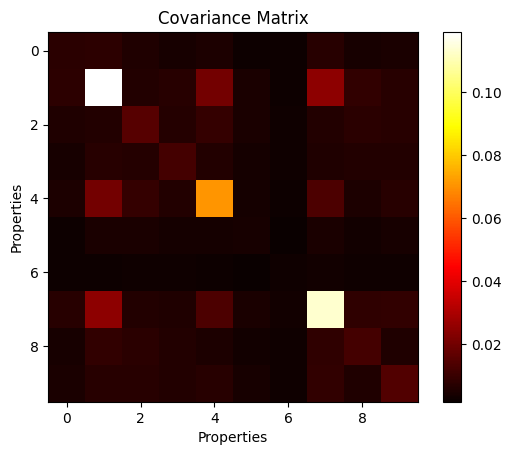

In [128]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

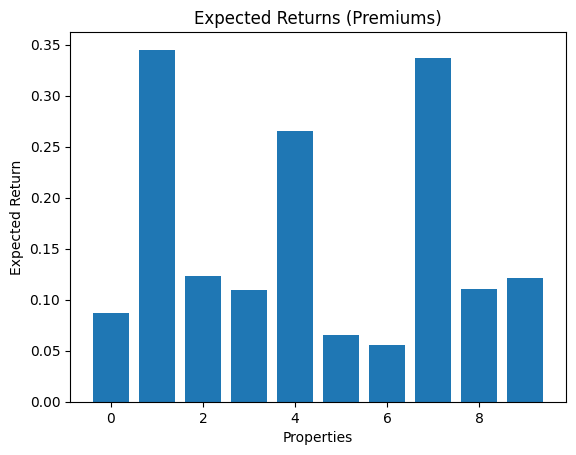

In [129]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

BUILD QUBO MATRIX

In [130]:
lambda_ = 0.1    # trade-off: reward return vs. minimize correlation
P = 100          # 10 is too low!
n = n_properties
k = budget

# Start with the covariance matrix as risk
Q = sigma.copy()

# Add premium (expected return) as a negative reward
for i in range(n):
    Q[i, i] -= lambda_ * mu[i]

# Add constraint penalty: (sum x_i - k)^2
for i in range(n):
    Q[i, i] += P * (1 - 2 * k)
    for j in range(n):
        if i != j:
            Q[i, j] += P


In [131]:
print(Q)

[[-500.0010972   100.00779121  100.0058612   100.00416456  100.00499728
   100.00262297  100.00247766  100.00702952  100.00438299  100.00456692]
 [ 100.00779121 -499.91543285  100.00621818  100.00705738  100.02044933
   100.00465525  100.002693    100.02482896  100.00876066  100.00701536]
 [ 100.0058612   100.00621818 -499.99714185  100.00674506  100.00950617
   100.00455583  100.00296346  100.00592444  100.00738653  100.00707632]
 [ 100.00416456  100.00705738  100.00674506 -499.99891608  100.00628435
   100.00361746  100.00314369  100.00585669  100.00617938  100.00622939]
 [ 100.00499728  100.02044933  100.00950617  100.00628435 -499.95601584
   100.00383803  100.00266121  100.01347321  100.00531161  100.00716461]
 [ 100.00262297  100.00465525  100.00455583  100.00361746  100.00383803
  -500.00225666  100.00178288  100.00469767  100.00329983  100.00414961]
 [ 100.00247766  100.002693    100.00296346  100.00314369  100.00266121
   100.00178288 -500.00246626  100.00338835  100.00299957 

In [132]:
J = np.zeros((n, n))
h = np.zeros(n)

for i in range(n):
    h[i] = -0.5 * Q[i, i]
    for j in range(i + 1, n):
        J[i, j] = 0.25 * Q[i, j]
        h[i] += 0.25 * Q[i, j]
        h[j] += 0.25 * Q[i, j]


In [133]:
import pennylane as qml

coeffs = []
obs = []

for i in range(n):
    coeffs.append(h[i])
    obs.append(qml.PauliZ(i))

for i in range(n):
    for j in range(i + 1, n):
        if J[i, j] != 0:
            coeffs.append(J[i, j])
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

H = qml.Hamiltonian(coeffs, obs)
print(H)

475.0115221784969 * Z(0) + 449.9781359611531 * Z(1) + 425.0096103740132 * Z(2) + 400.007285782579 * Z(3) + 374.9861200872399 * Z(4) + 350.00461082712815 * Z(5) + 325.0035930170872 * Z(6) + 299.96458495752574 * Z(7) + 275.00088549894804 * Z(8) + 249.99874316612286 * Z(9) + 25.00194780322341 * (Z(0) @ Z(1)) + 25.001465298885545 * (Z(0) @ Z(2)) + 25.001041140108644 * (Z(0) @ Z(3)) + 25.00124932078588 * (Z(0) @ Z(4)) + 25.00065574343193 * (Z(0) @ Z(5)) + 25.000619415822896 * (Z(0) @ Z(6)) + 25.00175737894386 * (Z(0) @ Z(7)) + 25.00109574809167 * (Z(0) @ Z(8)) + 25.00114173070622 * (Z(0) @ Z(9)) + 25.001554545989517 * (Z(1) @ Z(2)) + 25.001764346209175 * (Z(1) @ Z(3)) + 25.005112333529205 * (Z(1) @ Z(4)) + 25.001163813033745 * (Z(1) @ Z(5)) + 25.000673250099126 * (Z(1) @ Z(6)) + 25.00620724076551 * (Z(1) @ Z(7)) + 25.002190165030807 * (Z(1) @ Z(8)) + 25.001753841086266 * (Z(1) @ Z(9)) + 25.00168626593556 * (Z(2) @ Z(3)) + 25.00237654157627 * (Z(2) @ Z(4)) + 25.001138956708953 * (Z(2) @ Z(5)

In [134]:
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n):
        for j in range(i+1, n):
            qml.CNOT(wires=[i, j])

    return qml.expval(H)



(<Figure size 4900x1100 with 1 Axes>, <Axes: >)


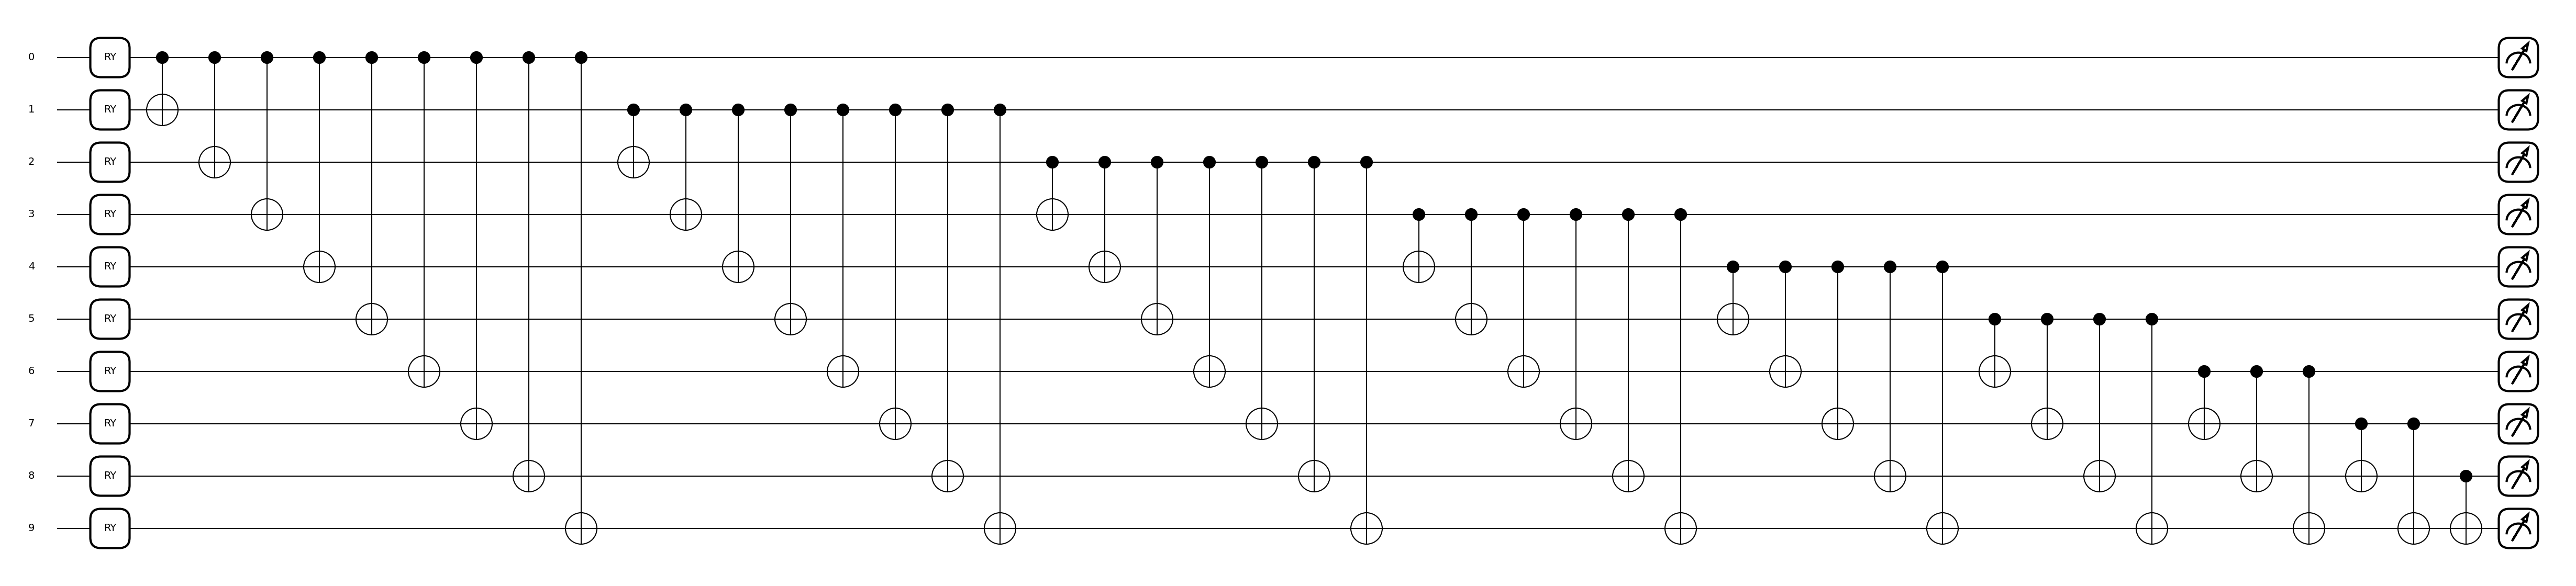

In [135]:
print(qml.draw_mpl(circuit, max_size=5)(np.zeros(n)))

In [136]:
def cost_fn(params):
    return circuit(params)  # this returns ⟨H⟩


In [137]:
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

# Create trainable parameters correctly
params = np.tensor(np.random.uniform(0, np.pi, size=n), requires_grad=True)

opt = AdamOptimizer(stepsize=0.1)
steps = 100

for i in range(steps):
    params = opt.step(cost_fn, params)
    if i % 10 == 0:
        energy = cost_fn(params)
        print(f"Step {i:3d} | Cost (Energy): {energy:.6f}")


Step   0 | Cost (Energy): -14.380619
Step  10 | Cost (Energy): -1282.058298
Step  20 | Cost (Energy): -1774.493887
Step  30 | Cost (Energy): -1762.675130
Step  40 | Cost (Energy): -1811.495787
Step  50 | Cost (Energy): -1831.232104
Step  60 | Cost (Energy): -1854.828270
Step  70 | Cost (Energy): -1866.518375
Step  80 | Cost (Energy): -1875.901845
Step  90 | Cost (Energy): -1886.126206


In [138]:
print(params)

[ 3.13925871  0.0066974  -2.43130851  3.12194081 -0.00484549  3.13618852
 -0.06729135  0.06648859  3.14007344 -0.00371014]


Let's sample now to find the optimal bitstring

In [139]:
dev = qml.device("default.qubit", wires=n, shots=1000)  # 👈 Add shots here

@qml.qnode(dev)
def sampling_circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.sample(wires=range(n))


In [140]:
samples = sampling_circuit(params)  # shape = (shots, n)
from collections import Counter

bitstrings = ["".join(str(b) for b in sample) for sample in samples]
counts = Counter(bitstrings)

# Print the most frequent samples
for bitstring, count in counts.most_common(5):
    print(f"{bitstring} -> {count} times")


1101100011 -> 864 times
1110011100 -> 133 times
1101101100 -> 2 times
1101100100 -> 1 times


In [141]:
def evaluate_energy(x):
    z = 1 - 2 * np.array(x)  # convert 0/1 → ±1
    energy = sum(h[i] * z[i] for i in range(n))
    energy += sum(J[i, j] * z[i] * z[j] for i in range(n) for j in range(i+1, n))
    return energy

# Get all sample energies
sample_energies = [(sample, evaluate_energy(sample)) for sample in samples]
best_sample = min(sample_energies, key=lambda x: x[1])[0]



In [142]:
print(evaluate_energy([0,1,0,0,1,0,0,1,0,0]))

1450.11323161775


In [143]:
print(evaluate_energy(best_sample))

-1099.986875267117


In [144]:
print("Best decision vector X:", best_sample)

Best decision vector X: [1 1 1 0 0 1 1 1 0 0]
